In [3]:
import os
import csv
from PIL import Image
import numpy as np
import numpy.linalg as la
from scipy import linalg
from scipy import spatial
from scipy import signal
import matplotlib.pyplot as plt
from math import *
import time

%matplotlib inline

$$\phi(\mathbf{x}) = \mathbf{a}\cdot\mathbf{x} + \frac{1}{2}\mathbf{x}^TA\mathbf{x} - a_5e^{-\frac{1}{2}|x+\mathbf{a}_m|^2}$$
where $$\mathbf{x} = (x_0,x_1),\mathbf{a} = (a_0,a_1), A = 
                                \begin{pmatrix}
                                    1+a_2 & a_3\\
                                    a_3 & 1+a_4
                                \end{pmatrix}, \mathbf{a}_m = (a_6,a_7)$$

$$g(\mathbf{z}) = b_0 + \mathbf{b}\cdot\mathbf{z} + \frac{1}{2}\mathbf{z}^TB\mathbf{z} + b_6e^{-\frac{1}{2}|\mathbf{z}+\mathbf{b}'|^2} + b_{9}e^{-\frac{1}{2}|\mathbf{z}+\mathbf{b}''|^2}$$
where
$$\mathbf{b} = (b_1,b_2), B=\begin{pmatrix}
                                b_3 & b_4\\
                                b_4 & b_5
                            \end{pmatrix}, \mathbf{b}' = (b_7,b_8), \mathbf{b}'' = (b_{10},b_{11})$$

$$
T(\mathbf{x}) = \nabla\phi(\mathbf{x})=  \begin{pmatrix} a_0 + (1+a_2) x_0 + a_3 x_1 + a_5(x_0+a_6) e^{-0.5((x_0+a_6)^2 + (x_1+a_7)^2)} \\ a_1 + (1+a_4) x_1 + a_3 x_0 + a_5 (x_1+a_7) e^{-0.5((x_0+a_6)^2 + (x_1+a_7)^2)} \end{pmatrix}\\
 = T_0(x) + T_1(x)
$$
and  
$$
g(\mathbf{z}) =b_0 + b_1 z_0 + b_2 z_1 + 0.5 b_3 z_0^2 + b_4 z_0z_1 + 0.5 b_5 z_1^2 + b_6 \exp \left( -\frac{1}{2}((z_0+b_7)^2 + (z_1+b_8)^2) \right) + b_{9} \exp \left( -\frac{1}{2}((z_0+b_{10})^2 + (z_1+b_{11})^2) \right) \\
 = g_0(z) + g_1(z) + g_2(z)
$$

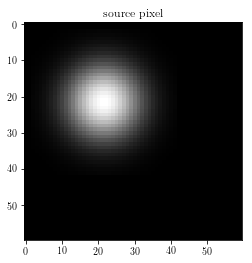

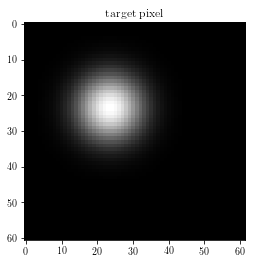

In [110]:
###x: Generate an image of 2D Gaussian kernel, with image size of 60x60 pixels###
###y: Generate an image of 2D Gaussian kernel, with image size of 61x62 pixels###
def gkern(kernlen, std):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d
def Gaussian_pixels(L1,W1,L2,W2,sizeG,std,nml,tr=3,sc=1):
    x_0 = np.zeros((L1*W1,2))
    for i in range(L1*W1):
        x_0[i][0] = (i//W1)/L1
        x_0[i][1] = (i%W1)/W1

    # y_0 = x_0
    
    y_0 = np.zeros((L2*W2,2))
    for i in range(L2*W2):
        y_0[i][0] = (i//W2)/L2
        y_0[i][1] = (i%W2)/W2

    Gaussian_1 = gkern(sizeG,std)
    Gaussian_2 = gkern(sizeG,sc*std)
    
    rec_x = np.zeros((L1,W1))
    rec_y = np.zeros((L2,W2))
    rec_x[2:sizeG+2,2:sizeG+2] = Gaussian_1
    rec_y[2+tr:sizeG+2+tr,tr+2:sizeG+tr+2] = Gaussian_2

    pixels_1 = rec_x.flatten()
    n_pixels_1 = np.array([1.0/pixels_1.sum()*pixels_1])
    pixels_2 = rec_y.flatten()
    n_pixels_2 = np.array([1.0/pixels_2.sum()*pixels_2])

    x = np.concatenate(((L1/nml)*x_0,n_pixels_1.T),axis=1)
    y = np.concatenate(((L1/nml)*y_0,n_pixels_2.T),axis=1)
    
    return x,y,pixels_1,pixels_2
x,y,pixels_1,pixels_2 = Gaussian_pixels(60,60,61,62,40,7,60,tr=2,sc=0.9)
image_count = 0
faceX = np.reshape(pixels_1,(60,60))
image_count+=1
plt.figure(image_count)
plt.title('source pixel')
plt.imshow(faceX,cmap=plt.cm.gray)
# plt.show('hold')

faceX = np.reshape(pixels_2,(61,62))
image_count+=1
plt.figure(image_count)
plt.title('target pixel')
plt.imshow(faceX,cmap=plt.cm.gray)
# plt.show('hold')

In [92]:
def cutoff(x):
    ###drop pixels with intensity below a certain level; this case we drop pixels with intensity value 0
    nx = []
    for i in range(len(x)):
        if x[i][2] != 0:
            nx.append(x[i])
    return np.array(nx)
def LGH(x,y,a,b,returnGH=True,d=2):
    da = len(a)
    db = len(b)
    Nx = len(x)
    Ny = len(y)
    
    x0 = x[:,0]
    x1 = x[:,1]
    x0a6 = x0+a[6]
    x1a7 = x1+a[7]
    argexpT = (x0a6**2+x1a7**2)
    expT = np.exp(-0.5*argexpT)
    T = np.zeros((Nx,2))
    T[:,0] = a[0] + (1+a[2])*x0+a[3]*x1+a[5]*x0a6*expT
    T[:,1] = a[1] + a[3]*x0+(1+a[4])*x1+a[5]*x1a7*expT
    T0 = T[:,0]
    T1 = T[:,1]
    y0 = y[:,0]
    y1 = y[:,1]
    g0y = b[0]+ b[1]*y0+b[2]*y1+0.5*b[3]*y0**2+b[4]*y0*y1+0.5*b[5]*y1**2
    y0b7 = y0+b[7]
    y1b8 = y1+b[8]
    y0b10 = y0+b[10]
    y1b11 = y1+b[11]
    argexpy1 =  (y0b7**2+y1b8**2)
    expy1 = np.exp(-0.5*argexpy1)
    argexpy2 =  (y0b10**2+y1b11**2)
    expy2 = np.exp(-0.5*argexpy2)
    g1y = b[6]*expy1
    g2y = b[9]*expy2
    gy = g0y + g1y + g2y
    g0T =b[0]+ b[1]*T0+b[2]*T1+0.5*b[3]*T0**2+b[4]*T0*T1+0.5*b[5]*T1**2
    T0b7 = T0+b[7]
    T1b8 = T1+b[8]
    T0b10 = T0+b[10]
    T1b11 = T1+b[11]
    argexpT1 =  (T0b7**2+T1b8**2)
    expT1 = np.exp(-0.5*argexpT1)
    argexpT2 =  (T0b10**2+T1b11**2)
    expT2 = np.exp(-0.5*argexpT2)
    g1T = b[6]*expT1
    g2T = b[9]*expT2
    gT = g0T + g1T + g2T
    
    L = np.average(gT,weights=x[:,2]) - np.average(np.exp(gy),weights=y[:,2])
    
    if not returnGH:
        return(L)
    
    else:
        #first derivatives
        gzT = np.zeros((Nx,2))
        gzT[:,0] = b[1]+b[3]*T0+b[4]*T1
        gzT[:,0] += -b[6]*T0b7*expT1
        gzT[:,0] += -b[9]*T0b10*expT2
        gzT[:,1] = b[2]+b[4]*T0+b[5]*T1
        gzT[:,1] += -b[6]*T1b8*expT1
        gzT[:,1] += -b[9]*T1b11*expT2
        
        daT = np.zeros((Nx,da,d))
        daT[:,0,:] = np.array([1,0])
        daT[:,1,:] = np.array([0,1])
        daT[:,2,0] = x0
        daT[:,3,0] = x1
        daT[:,3,1] = x0
        daT[:,4,1] = x1
        
        daT[:,5,0] = expT*x0a6
        daT[:,5,1] = expT*x1a7
        daT[:,6,0] = a[5]*expT*(1-x0a6**2)
        daT[:,6,1] = -a[5]*expT*x0a6*x1a7
        daT[:,7,0] = daT[:,6,1]
        daT[:,7,1] = a[5]*expT*(1-x1a7**2)
        
        #gradient w.r.t. a
        ngzT = np.einsum('i,ij->ij',x[:,2],gzT)
        daL = np.einsum('ijk,ik->j',daT,ngzT)
        
        expgy = np.exp(gy)
        nexpgy = np.exp(gy)*y[:,2]
        dbgy = np.zeros((Ny,db))
        dbgT = np.zeros((Nx,db))
        dbgy[:,0] = np.ones(Ny)
        dbgT[:,0] = np.ones(Nx)
        dbgy[:,1] = y0
        dbgT[:,1] = T0
        dbgy[:,2] = y1
        dbgT[:,2] = T1
        dbgy[:,3] = 0.5*y0**2
        dbgT[:,3] = 0.5*T0**2
        dbgy[:,4] = y0*y1
        dbgT[:,4] = T0*T1
        dbgy[:,5] = 0.5*y1**2
        dbgT[:,5] = 0.5*T1**2
        
        dbgy[:,6] = expy1
        dbgT[:,6] = expT1
        dbgy[:,7] = -b[6]*y0b7*expy1
        dbgT[:,7] = -b[6]*T0b7*expT1
        dbgy[:,8] = -b[6]*y1b8*expy1
        dbgT[:,8] = -b[6]*T1b8*expT1
        dbgy[:,9] = expy2
        dbgT[:,9] = expT2
        
        dbgy[:,10] = -b[9]*y0b10*expy2
        dbgT[:,10] = -b[9]*T0b10*expT2
        dbgy[:,11] = -b[9]*y1b11*expy2
        dbgT[:,11] = -b[9]*T1b11*expT2
        
        #gradient w.r.t. b
        ndbgT = np.einsum('i,ij->ij',x[:,2],dbgT)
        dbL = np.sum(ndbgT,axis=0) - np.einsum('ik,i->k',dbgy,nexpgy)
        
        #gradient
        G = np.concatenate([daL,dbL],axis=0)
        
        #second derivatives
        gzzT = np.zeros((Nx,d,d))
        gzzT[:,0,0] = b[3] - b[6]*(1-T0b7**2)*expT1-b[9]*(1-T0b10**2)*expT2
        gzzT[:,1,0] = b[4] + b[6]*T0b7*T1b8*expT1+b[9]*T0b10*T1b11*expT2
        gzzT[:,0,1] = gzzT[:,1,0]
        gzzT[:,1,1] = b[5] - b[6]*(1-T1b8**2)*expT1-b[9]*(1-T1b11**2)*expT2
        
        daaT = np.zeros((Nx,da,da,d))
        
        daaT[:,5,6,0] = expT*(1-x0a6**2)
        daaT[:,5,6,1] = -expT*x0a6*x1a7
        daaT[:,5,7,0] = daaT[:,5,6,1]
        daaT[:,5,7,1] = expT*(1-x1a7**2)
        daaT[:,6,6,0] = -a[5]*expT*x0a6*(3-x0a6**2)
        daaT[:,6,6,1] = -a[5]*expT*x1a7*(1-x0a6**2)
        daaT[:,6,7,0] = daaT[:,6,6,1]
        daaT[:,6,7,1] = -a[5]*expT*(1-x1a7**2)*x0a6
        daaT[:,7,7,0] = daaT[:,6,7,1]
        daaT[:,7,7,1] = -a[5]*expT*x1a7*(3-x1a7**2)
        
        daaT[:,6,5,0] = daaT[:,5,6,0]
        daaT[:,6,5,1] = daaT[:,5,6,1]
        daaT[:,7,5,0] = daaT[:,5,7,0]
        daaT[:,7,5,1] = daaT[:,5,7,1]
        daaT[:,7,6,0] = daaT[:,6,7,0]
        daaT[:,7,6,1] = daaT[:,6,7,1]
   
        ngzzT = np.einsum('i,ijk->ijk',x[:,2],gzzT)
        daaL = np.einsum('ijkl,il->jk',daaT,ngzT) + np.einsum('ijl,ilm,ikm->jk',daT,ngzzT,daT)
        
        
        
        
        dbzgT = np.zeros((Nx,db,d))
        dbzgT[:,1,0]=np.ones(Nx)
        dbzgT[:,2,1]=np.ones(Nx)
        dbzgT[:,3,0]=T0
        dbzgT[:,4,0]=T1
        dbzgT[:,4,1]=T0
        dbzgT[:,5,1]=T1
        
        dbzgT[:,6,0]=-T0b7*expT1
        dbzgT[:,6,1]=-T1b8*expT1
        dbzgT[:,7,0]=-b[6]*expT1*(1-T0b7**2)
        dbzgT[:,7,1]=b[6]*T1b8*expT1*T0b7
        dbzgT[:,8,0]=dbzgT[:,7,1]
        dbzgT[:,8,1]=-b[6]*expT1*(1-T1b8**2)
        dbzgT[:,9,0]=-T0b10*expT2
        dbzgT[:,9,1]=-T1b11*expT2
        dbzgT[:,10,0]=-b[9]*expT2*(1-T0b10**2)
        dbzgT[:,10,1]=b[9]*T1b11*expT2*T0b10
        dbzgT[:,11,0]=dbzgT[:,10,1]
        dbzgT[:,11,1]=-b[9]*expT2*(1-T1b11**2)
        
        
        
        ndbzgT = np.einsum('i,ijk->ijk',x[:,2],dbzgT)
        
        # #Hessian w.r.t. ab
        dabL = np.einsum('ikl,ijl->jk',ndbzgT,daT)
        
        
        dbbgy = np.zeros((Ny,db,db))
        dbbgT = np.zeros((Nx,db,db))
        
        dbbgy[:,6,7] = -y0b7*expy1
        dbbgy[:,6,8] = -y1b8*expy1
        dbbgy[:,7,7] = -b[6]*expy1*(1-y0b7**2)
        dbbgy[:,7,8] = b[6]*y1b8*expy1*y0b7
        dbbgy[:,8,8] = -b[6]*expy1*(1-y1b8**2)
        dbbgy[:,9,10] = -y0b10*expy2
        dbbgy[:,9,11] = -y0b10*expy2
        dbbgy[:,10,10] = -b[9]*expy2*(1-y0b10**2)
        dbbgy[:,10,11] = b[9]*y1b11*expy2*y0b10
        dbbgy[:,11,11] =-b[9]*expy2*(1-y1b11**2)
        
        dbbgy[:,7,6] = dbbgy[:,6,7]
        dbbgy[:,8,6] = dbbgy[:,6,8]
        dbbgy[:,8,7] = dbbgy[:,7,8]
        dbbgy[:,10,9] = dbbgy[:,9,10]
        dbbgy[:,11,9] = dbbgy[:,9,11]
        dbbgy[:,11,10] = dbbgy[:,10,11]
        
        
        dbbgT[:,6,7] = -T0b7*expT1
        dbbgT[:,6,8] = -T1b8*expT1
        dbbgT[:,7,7] = -b[6]*expT1*(1-T0b7**2)
        dbbgT[:,7,8] = b[6]*T1b8*expT1*T0b7
        dbbgT[:,8,8] = -b[6]*expT1*(1-T1b8**2)
        dbbgT[:,9,10] = -T0b10*expT2
        dbbgT[:,9,11] = -T0b10*expT2
        dbbgT[:,10,10] = -b[9]*expT2*(1-T0b10**2)
        dbbgT[:,10,11] = b[9]*T1b11*expT2*T0b10
        dbbgT[:,11,11] =-b[9]*expT2*(1-T1b11**2)
        
        dbbgT[:,7,6] = dbbgT[:,6,7]
        dbbgT[:,8,6] = dbbgT[:,6,8]
        dbbgT[:,8,7] = dbbgT[:,7,8]
        dbbgT[:,10,9] = dbbgT[:,9,10]
        dbbgT[:,11,9] = dbbgT[:,9,11]
        dbbgT[:,11,10] = dbbgT[:,10,11]


        dbgdbg = np.einsum('jn,jm->jnm',dbgy,dbgy)
        ndbbgT = np.einsum('i,ijk->ijk',x[:,2],dbbgT)
        
        dbbL = np.sum(ndbbgT,axis=0) - np.einsum('jnm,j->nm',(dbbgy+dbgdbg),nexpgy)
        
        #Hessian
        H = np.zeros((da+db,da+db))
        H[:da,:da] = daaL
        H[:da,da:] = dabL
        H[da:,:da] = dabL.T
        H[da:,da:] = dbbL
        return(L,G,H)

In [105]:
def local_ot_debug(x, y, Niter=200, eps=1e-5, eta0=0.05, da=8, db=12, eta_min = 1e-4, eta_max=1e6, gamma = 5.2):
    x_c = cutoff(x)
    y_c = cutoff(y)
    Nx = len(x)
    Ny = len(y)

    eta = eta0
    etaC = 2.0

    #setting up initial b, and minvar,D
    vx = np.cov(x[:,:2].T,aweights=x[:,2])
    vy = np.cov(y[:,:2].T,aweights=y[:,2])
#     vx = np.cov(x_c[:,:2].T)
#     vy = np.cov(y_c[:,:2].T)
    mx = np.average(x[:,:2],axis=0,weights=x[:,2])
    my = np.average(y[:,:2],axis=0,weights=y[:,2])

    a0 = np.zeros(da)
    #initial b
    b0 = np.zeros(db)
    B0 = 0.5*(la.inv(vy)-la.inv(vx))
    b0[3] = B0[0,0]
    b0[4] = B0[0,1]+B0[1,0]
    b0[5] = B0[1,1]
    B1 = la.solve(vx,mx) - la.solve(vy,my)
    b0[1] = B1[0]
    b0[2] = B1[1]
    b0[0] = 0.5*(my.dot(la.solve(vy,my)) - mx.dot(la.solve(vx,mx))+np.log(la.det(vy)/la.det(vx)))
    b0[7:9] = 0.1*np.random.uniform(low=-1.0,high=1.0,size=2)
    b0[10:] = 0.1*np.random.uniform(low=-1.0,high=1.0,size=2)

    z = np.concatenate([a0,b0],axis=0)
    J = np.eye(da+db)
    J[da:,da:] *= -1

    #   initialize gradients  
    a = a0
    b = b0
    Ln,Gn,Hn = LGH(x,y,a,b)

    x0 = x[:,0]
    x1 = x[:,1]

    T = np.zeros((Nx,3))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1
    T[:,2] = x[:,2]
    
    ####debug####  
    listG = []
    listeta = []
    Lnn = []
    Lnnp1 = []
    Lnp1n = []
    #############
    
    for n in range(Niter):
        zold = z
        nz = z
        Gn_norm = la.norm(Gn,2)
        ###################
        listG.append(la.norm(Gn,2))
        listeta.append(eta)
        ###################
        
        if Gn_norm < eps:
            break
        #   delta = (delta0-deltainf)*np.exp(-5*(n+1)/Niter) + deltainf
        validity = False
        eta = min(gamma*eta, eta_max)
        iters = 0
        while(not validity):
            iters += 1
            eta = eta/2.0
            if eta < eta_min:
                break
            dz = -la.solve((1.0/eta)*J+Hn,Gn)
            nz = zold + dz
            Ln1 = LGH(x,y,nz[:da],nz[da:],returnGH=False)
            Lan1 = LGH(x,y,nz[:da],zold[da:],returnGH=False)
            Lbn1 = LGH(x,y,zold[:da],nz[da:],returnGH=False)
            v_0 = (Ln1<=Lbn1+1e-16) and (Lan1<=Ln1+1e-16)
            validity = v_0 or (iters>=10)
        z = z + dz
        Lnn.append(Ln1)
        Lnnp1.append(Lbn1)
        Lnp1n.append(Lan1)
        Ln,Gn,Hn = LGH(x,y,z[:da],z[da:])
    a,b = z[:da],z[da:]
    T = np.zeros((Nx,3))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1
    T[:,2] = x[:,2]
    
    return T,a,b,[listG,listeta,Lnn,Lnnp1,Lnp1n]

ValueError: x and y must have same first dimension, but have shapes (799,) and (800,)

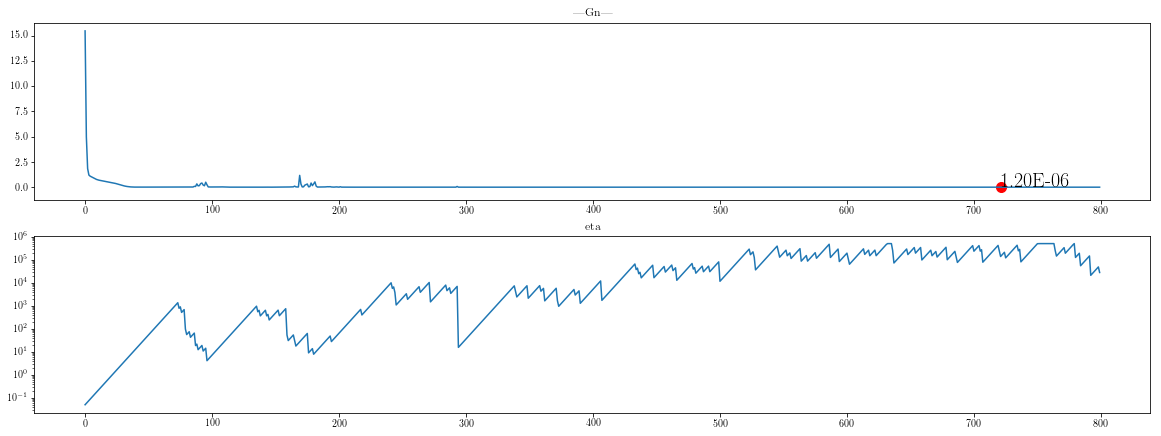

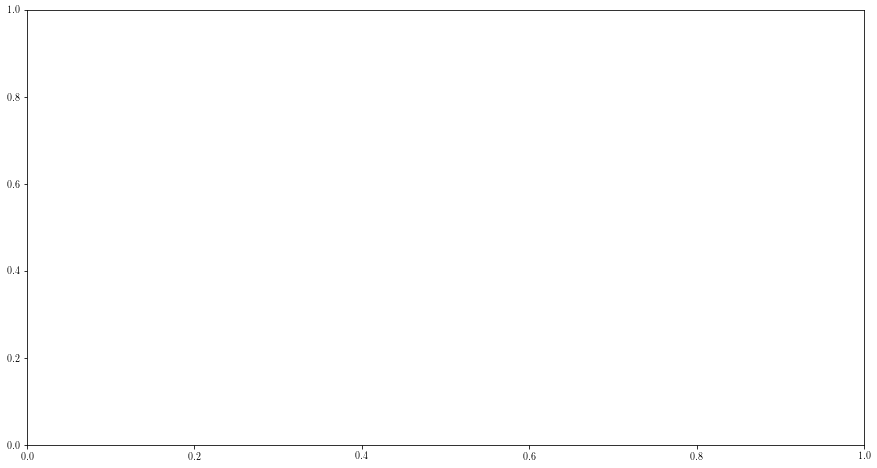

In [111]:
#Test the local algorithm
T, a, b, Ls= local_ot_debug(x,y,Niter=800,eps=1e-6,eta0=0.05,gamma = 2.3)
from decimal import Decimal
from matplotlib import rc
#####DEBUG#####
#find minimal Gn, Dn
minG = np.min(Ls[0])
iminG = np.argmin(Ls[0])

fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(Ls[0])
ax1.scatter(iminG,minG, c = 'r', s = 100)
decG = '%.2E' % Decimal(minG)
ax1.annotate(decG, (iminG,minG+0.1), fontsize=20)
ax1.set_title('|Gn|')
# ax1.axvline(iminD, c = 'black', ls = 'dotted')

ax2 = fig.add_subplot(4, 1, 2)
ax2.semilogy(Ls[1])
# ax4.axvline(iminD, c = 'black', ls = 'dotted')
ax2.set_title('eta');
###############
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
iterations = range(len(Ls[0])-1)
plt.plot(iterations,Ls[2], label=r'$L^{n+1,n+1}$', c='C1')
plt.plot(iterations,Ls[3], label=r'$L^{n+1,n}$', c='C0', linestyle='--')
plt.plot(iterations,Ls[4], label=r'$L^{n,n+1}$',c='C2', linestyle='--')
plt.legend()
# plt.ylim(ymin=-1.00001, ymax=-0.99999)
print(a,b)

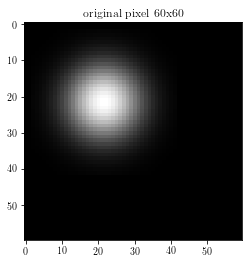

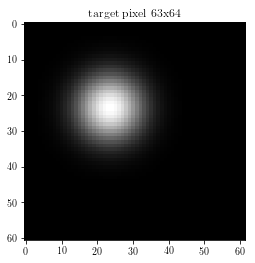

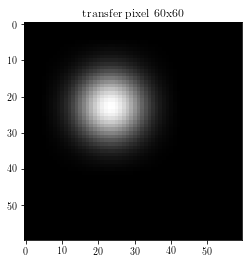

In [112]:
#plot the new image generated by optimal transport
def rho_T(x,T,rho_x,delta = 5e3):
    T0 = T[:,0]
    T1 = T[:,1]
    x0T0 = x[0]-T[:,0]
    x1T1 = x[1]-T[:,1]
    argexp = -delta*(x0T0**2+x1T1**2)
    exp_v = np.exp(argexp)
    return exp_v.dot(rho_x)
pixels_T = np.array([rho_T(x[i,:2],T[:,:2],T[:,2]) for i in range(len(x))])
image_count = 0
faceX = np.reshape(pixels_1,(60,60))
image_count+=1
plt.figure(image_count)
plt.title('original pixel 60x60')
plt.imshow(faceX,cmap=plt.cm.gray)
plt.show('hold')

faceY = np.reshape(pixels_2,(61,62))
image_count+=1
plt.figure(image_count)
plt.title('target pixel 63x64')
plt.imshow(faceY,cmap=plt.cm.gray)
plt.show('hold')

faceT = np.reshape(pixels_T,(60,60))
image_count+=1
plt.figure(image_count)
plt.title('transfer pixel 60x60')
plt.imshow(faceT,cmap=plt.cm.gray)
plt.show('hold')

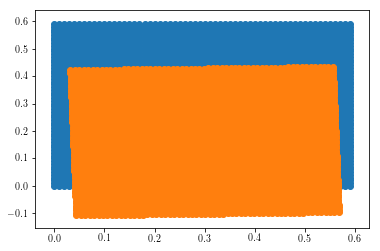

In [113]:
plt.scatter(x[:,0],x[:,1])
plt.scatter(T[:,0],T[:,1])

In [104]:
a = [0.008,0.008,0,0,0,0,0,0]
b = 12*[0]
L,G,H = LGH(x,y,a,b)
print(la.norm(G,2))

0.01049299342817983
